In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [5]:
#Preperation of data as done in the Exploration

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.numeric(train.data$Intensity) -1

#Output variable
y <- train.data$VALENCE.PLEASANTNESS

#Data without predictors with a correlation index above 0.95
library(caret)

corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.95)  # removes all indices of features which have a correlation of 0.95 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data

## Linear Regression with Lasso Regularization and 5-Fold Cross Validation

First, Lasso regularization method is used. This process aims at restricting the features while modelling to minimize the risk of overfitting. We will also test this method with both correlated and uncorrelated variables to see if we have a difference in the validation MSE.

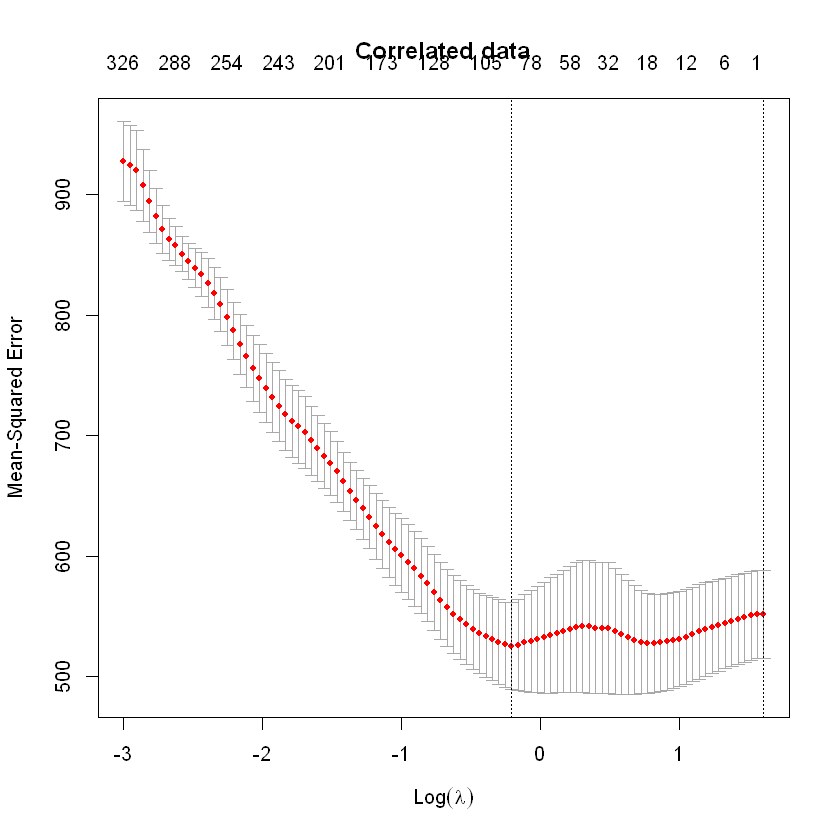

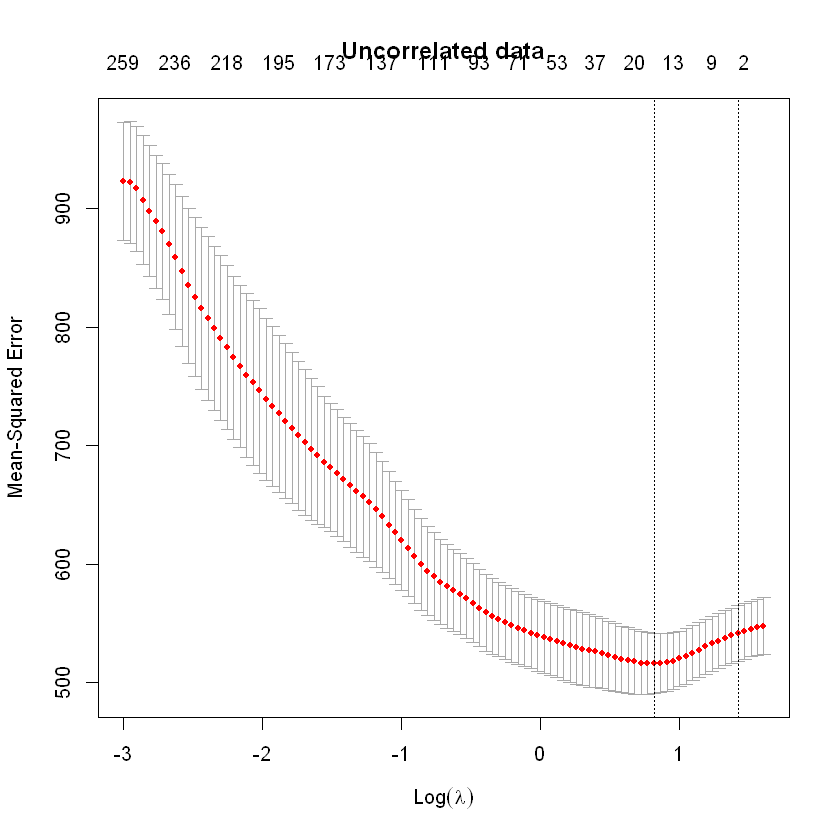

In [6]:
set.seed(100)

library(glmnet)

#split the training data in a training set and a validation set for correlated data
len <- length(x[,1])
idx.train <- sample(1:len, 2*len/3)

train.x <- as.matrix(x[idx.train,])
train.y <- as.matrix(y[idx.train])
val.x <- as.matrix(x[-idx.train,])
val.y <- as.matrix(y[-idx.train])

#split the training data in a training set and a validation set for uncorrelated data
corr.train.x <- as.matrix(corr.x[idx.train,])
corr.train.y <- as.matrix(y[idx.train])
corr.val.x <- as.matrix(corr.x[-idx.train,])
corr.val.y <- as.matrix(y[-idx.train])


#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 1, nfold = 5)
plot(cv.lasso, main = "Correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 1, nfold = 5)
plot(corr.cv.lasso, main = "Uncorrelated data")

One can see that it is clearly better to not include all variables for a linear regression (as expected).  

In [7]:
#best prediction for correlated
best.lasso <- glmnet(train.x, train.y, alpha = 1, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = (val.x))
#best prediction for uncorrelated
corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 1, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 436.7663

[1] 475.3553

The validation MSE has decreased significantly with Lasso regression with 5-fold cross validation.

## Linear Regression with Ridge Regularization and 5-Fold Cross Validation

In [8]:
#Ridge Regression models
lasso.mod <- glmnet(train.x,train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))
corr.lasso.mod <- glmnet(corr.train.x,corr.train.y, alpha = 0, lambda = 10^seq(1, -2, length = 150))

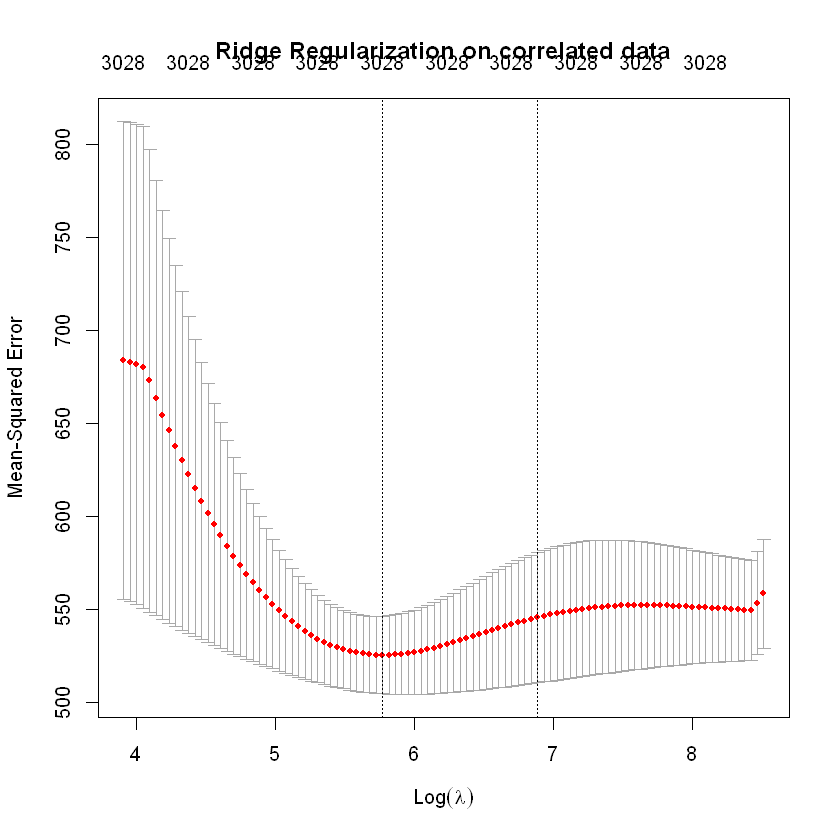

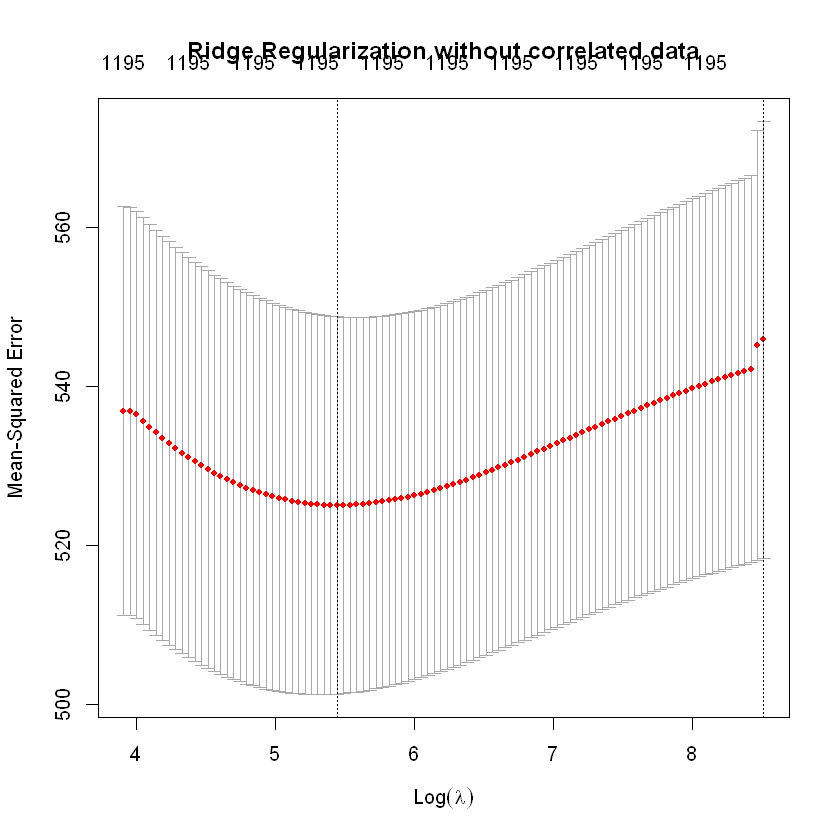

In [9]:
#5-fold cross-validation to find the optimal value for the parameter lambda
cv.lasso <- cv.glmnet(train.x, train.y, alpha = 0, nfold = 5)
plot(cv.lasso, main = "Ridge Regularization on correlated data")

corr.cv.lasso <- cv.glmnet(corr.train.x, corr.train.y, alpha = 0, nfold = 5)
plot(corr.cv.lasso, main = "Ridge Regularization without correlated data")

In [10]:
#best prediction for both correlated and uncorrelated variables 

best.lasso <- glmnet(train.x, train.y, alpha = 0, lambda = cv.lasso$lambda.min)
pred <- predict(best.lasso, s = cv.lasso$lambda.min, newx = val.x)

corr.best.lasso <- glmnet(corr.train.x, corr.train.y, alpha = 0, lambda = corr.cv.lasso$lambda.min)
corr.pred <- predict(corr.best.lasso, s = corr.cv.lasso$lambda.min, newx = as.matrix(corr.val.x))

#MSE with best lasso prediction 
mean((pred - val.y)^2)
mean((corr.pred - corr.val.y)^2)

[1] 448.346

[1] 450.4643

Ridge Regression does not result in a significant change in the MSE and does not change with correlated or uncorrelated variables. 

Since the MSE does not diminish significantly when we remove correlated variables (actually, it increases), we conserve all 3028 predictors for the further analyse.

Now we will try stepwise feature selection. Stepwise regression is a method of fitting regression models in which the choice of predictive variables is carried out by an automatic procedure. 
We will do the Forward Selection technique 

## Forward Selection with 5-Fold Cross-Validation

In [13]:
set.seed(100)

library(tidymodels)
library(leaps)

#functions 
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}


evaluate <- function(fold, fit, formula = VALENCE.PLEASANTNESS ~ .) {
    valid.set <- assessment(fold)
    sapply(seq(1, fit$nvmax - 1),
           function(id) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, id, formula))^2))
}

fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ .) {
    fit <- regsubsets(formula, analysis(fold), method = "forward", nvmax = 30)
    evaluate(fold, fit)
}

#data
full.data <- x
full.data$VALENCE.PLEASANTNESS <- y
validation.data <- vfold_cv(full.data, v = 5)           
           
cv.errors <- sapply(validation.data$splits, fit_and_evaluate)
mean.cv.errors <- rowMeans(cv.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2715  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2706  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2706  linear dependencies found"


Reordering variables and trying again:


We obtained a validation MSE =  502.0011  for  9  predictors

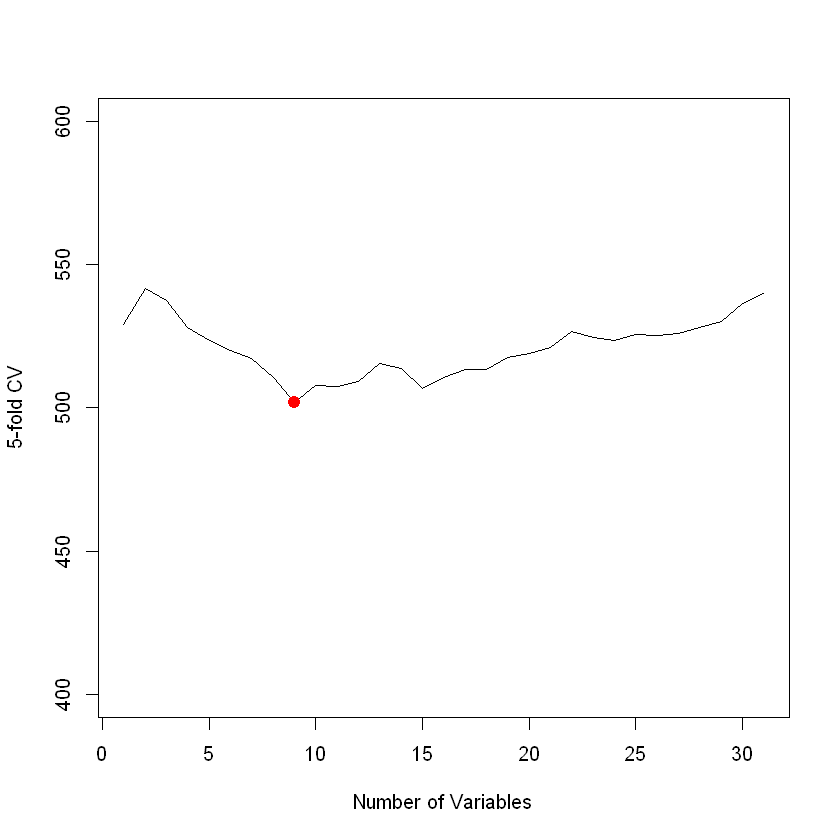

In [14]:
#plot the obtained data
plot(mean.cv.errors, type = "l", ylim = c(400, 600), xlab = "Number of Variables", ylab = "5-fold CV")
cv.min <- which.min(mean.cv.errors)
points(cv.min, mean.cv.errors[cv.min], col = "red", cex = 2, pch = 20)
abline(sd(full.data$VALENCE.PLEASANTNESS), 0, lty = "dashed")

cat("We obtained a validation MSE = ",mean.cv.errors[cv.min], " for ", which.min(mean.cv.errors), " predictors")

We can see that the best predictions are obtained with a small number of variables (9 variables). 